## Simple Generative Adverserial Network (GAN) only using Dense Layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten 
from tensorflow.keras.layers import BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras import Model
import matplotlib.pyplot as plt


import random
random.seed(42)

## Loading The Fashion MNIST Dataset

In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()

# Adding extra dimension i.e channel to the dataset
x_train = x_train[..., tf.newaxis].astype('float32') / 255.
x_test = x_test[..., tf.newaxis].astype('float32') / 255.

img_shape = x_train[1].shape
img_shape

(28, 28, 1)

## Building the Model
### Steps to train GANs :
1. First Train Discriminator to distinguish real and fake images.
2. Train generator to generate images and fool the discriminator.

## Discriminator

In [ ]:
def discriminator():

    model = tf.keras.Sequential(name='GENERATOR')
    model.add(Flatten(input_shape=img_shape, name='Input_Layer'))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(img_shape)
    model.summary()

    # Discriminatort's guess whether the image is real or fake
    output = model(img)

    return Model(img, output)

optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
# Generator will be trained as part of the combined model, later. 
discriminator = discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "GENERATOR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (Flatten)       (None, 784)               0         
                                                                 
 dense_57 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_58 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               32896     
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 128)               0 

## Generator

In [ ]:
def generator():

    # Random input given to the generator of GAN
    InputShape = (100, )


    model = tf.keras.Sequential(name='Generator')
    model.add(Dense(256, input_shape=InputShape, name='Input_Layer'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(784))
    model.add(Reshape(img_shape))

    model.summary()

    input = Input(shape=InputShape)

    # Output of Generator i.e Generated image
    img = model(input)
    
    return Model(input, img)

#SInce we are only generating (faking) images, let us not track any metrics.
generator = generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (Dense)         (None, 256)               25856     
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_18 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_61 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_19 (Bat  (None, 512)              2048      
 chNormalization)                                        

## Combining Generator and Discriminator

In [ ]:

## This builds the Generator and defines the input noise. 
# In a GAN the Generator network takes noise as an input to produce its images.  
random_noise = Input(shape=(100,))   #Our random input to the generator
img = generator(random_noise)

#This ensures that when we combine our networks we only train the Generator.
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator

valid = discriminator(img)  #Validity check on the generated image


#Here we combined the generator and discriminator to create final model. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator. 

combined = Model(random_noise, valid, name='Combined')
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

combined.summary()

Model: "Combined"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100)]             0         
                                                                 
 model_21 (Functional)       (None, 28, 28, 1)         1493520   
                                                                 
 model_20 (Functional)       (None, 1)                 566273    
                                                                 
Total params: 2,059,793
Trainable params: 1,489,936
Non-trainable params: 569,857
_________________________________________________________________


## Training the Model

### Saving Images at Predefined Intervals

In [ ]:
#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("/content/results/Epoch-%d.png" % epoch)
    plt.close()
#This function saves our images for us to view

In [ ]:
def train(epochs, batch=128, save_interval=200):

    #Lets loop through a number of epochs to train our Discriminator by first selecting
    #a random batch of images from our true dataset, generating a set of images from our
    #Generator, feeding both set of images into our Discriminator 

    for epoch in range(epochs):

        #---------------------------
        # Training the Discriminator
        #---------------------------

        # Sampling a batch of 64 images from x_train dataset
        indexes = np.random.randint(0, x_train.shape[0], 64)
        imgs = x_train[indexes]

        # Lets generate false images to train the discriminator 
        random_noise = np.random.normal(0, 1, size=(64, 100))
        gen_imgs = generator.predict(random_noise)

        # For calculating loss, Let's Train the discriminator on real images
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((64, 1)))

        # Training discriminator on fake images
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((64, 1)))

        ## 'train_on_batch' trains using single batch only and once.

        ## Taking average loss
        disc_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 


        #---------------------------
        # Training The Generator
        #---------------------------
        
        ## Feeding 100 different random inputs to the generator
        gen_input = np.random.normal(0, 1, size=(batch, 100))
        
        # Lets trick discriminator into believing the generated images are valid
        valid_y = np.array([1]*batch)

        # Generator is part of combined where it got directly linked with the discriminator
        g_loss = combined.train_on_batch(gen_input, valid_y)


        # Plot the progress
        
        print ("[epoch : %d/%d | Discriminator loss: %f, accuracy.: %.2f%%  | Generator loss: %f]" % (epoch, epochs, disc_loss[0], 100*disc_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)


train(epochs=10000, batch=128, save_interval=100)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4
generator.save('generator_model.h5')

Streaming output truncated to the last 5000 lines.
[Epoch-5000  Discriminator loss: 0.189185, accuracy.: 92.97%   Generator loss: 9.319767]
[Epoch-5001  Discriminator loss: 0.086768, accuracy.: 96.88%   Generator loss: 9.087206]
[Epoch-5002  Discriminator loss: 0.133513, accuracy.: 95.31%   Generator loss: 10.966444]
[Epoch-5003  Discriminator loss: 0.094140, accuracy.: 96.88%   Generator loss: 12.971340]
[Epoch-5004  Discriminator loss: 0.188270, accuracy.: 92.19%   Generator loss: 10.583814]
[Epoch-5005  Discriminator loss: 0.202670, accuracy.: 91.41%   Generator loss: 10.711082]
[Epoch-5006  Discriminator loss: 0.156336, accuracy.: 93.75%   Generator loss: 11.496545]
[Epoch-5007  Discriminator loss: 0.163352, accuracy.: 93.75%   Generator loss: 12.038293]
[Epoch-5008  Discriminator loss: 0.237395, accuracy.: 89.84%   Generator loss: 10.498489]
[Epoch-5009  Discriminator loss: 0.254079, accuracy.: 92.19%   Generator loss: 12.393238]
[Epoch-5010  Discriminator loss: 0.147625, accuracy

## Results

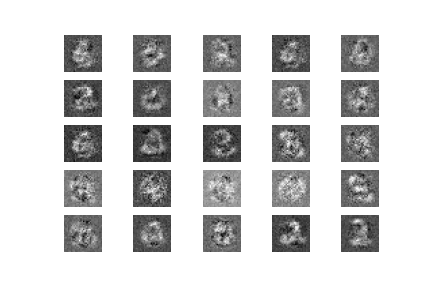

In [ ]:
import PIL

# Generated images at particulat epoch
def display_images(epoch_no):
  return PIL.Image.open(f'/content/results/Epoch-{epoch_no}.png')

## Generated images at 10000'th epoch
display_images(9900)

### Create a GIF

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import imageio
import glob


anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/results/Epoch-*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)